In [ ]:
import cv2
import skimage.io as io
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import helper as helper
from dataset import *
import imageio


In [ ]:
from  custom_loss import SinkhornDistance

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

n_points = 5
a = np.array([[i, 0] for i in range(n_points)])
b = np.array([[i, 1] for i in range(n_points)])

plt.figure(figsize=(6, 3))
plt.scatter(a[:, 0], a[:, 1], label='supp($p(x)$)')
plt.scatter(b[:, 0], b[:, 1], label='supp($q(x)$)')
plt.legend();


x = torch.tensor(a, dtype=torch.float)
y = torch.tensor(b, dtype=torch.float)
print(y.shape)

sinkhorn = SinkhornDistance(eps=0.1, max_iter=100)
dist, P, C = sinkhorn(x, y)
print("Sinkhorn distance: {:.3f}".format(dist.item()))


In [ ]:
label_path='../labels/coco/labels/val2017/000000007108.txt'
with open(label_path) as box:
    box=box.read()
    box=pd.DataFrame([x.split() for x in box.rstrip('\n').split('\n')],columns=['class','xc','yc','w','h'])

b= box.values.astype(np.float32)
bboxes=b
b=torch.tensor(b)
labels = b.T[0].reshape(b.shape[0], 1)
one_hot_target = (labels == torch.arange(80).reshape(1, 80)).float()
conf=torch.ones([b.shape[0],1])
boxes=torch.cat((b.T[1:],conf.T,one_hot_target.T)).T

img_path='../images/val2017/000000007108.jpg'
img=cv2.imread(img_path)[:,:,::-1] 

sample={'images': img,
        'boxes': boxes}

(h,w,c)=img.shape

bboxes[:,1]=bboxes[:,1]*w
bboxes[:,2]=bboxes[:,2]*h
bboxes[:,3]=bboxes[:,3]*w
bboxes[:,4]=bboxes[:,4]*h
bboxes[:,1]=bboxes[:,1]-bboxes[:,3]/2
bboxes[:,2]=bboxes[:,2]-bboxes[:,4]/2
bboxes[:,3]=bboxes[:,1]+bboxes[:,3]
bboxes[:,4]=bboxes[:,2]+bboxes[:,4]
print(bboxes)


In [ ]:
import imgaug as ia
from imgaug import parameters as iap
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


image = sample['images']

bbs = BoundingBoxesOnImage([
    BoundingBox(x1=b[1], y1=b[2], x2=b[3], y2=b[4], label=b[0]) for b in bboxes], shape=image.shape)

seq = iaa.OneOf([
            iaa.Sequential([
                iaa.LinearContrast(alpha=(0.1, 1.9)),
                iaa.Fliplr(0.5)
            ]),
            iaa.Sequential([
                iaa.Grayscale(alpha=(0.1, 0.9)),
                iaa.Affine(
                translate_px={"y": (-150, 150)}
            )
            ]),
            iaa.Sequential([
                iaa.Solarize(0.5, threshold=(0, 256)),
                iaa.ShearX((-10, 10))
            ]),
            iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.ShearY((-10, 10))
            ]),
            iaa.Sequential([
                iaa.Multiply((0.8, 1.2), per_channel=0.2),
                iaa.Affine(
                rotate=(-30, 30)
            )
            ]),
            iaa.Sequential([
                iaa.HistogramEqualization(),
                iaa.Affine(
                translate_px={"x": (-150, 150)}
            )
            ]),
            iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}
            )
            ])
        ])

# Augment BBs and images.
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

# image with BBs before/after augmentation (shown below)
# image_before = bbs.draw_on_image(image, size=2)
# image_after = bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255])

In [ ]:
new_bboxes=bbs_aug.to_xyxy_array()
bbs_aug=bbs_aug.remove_out_of_image().clip_out_of_image()

ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

labels=np.array([[box.label for box in bbs_aug.bounding_boxes]]).T
new_bboxes=bbs_aug.to_xyxy_array()
np.hstack((labels,new_bboxes))

bboxes_final=helper.convert2_rel(np.hstack((labels,new_bboxes)),image_aug.shape)
print(bboxes_final)

In [ ]:
ia.imshow(bbs.draw_on_image(image, size=2))
imageio.imwrite("elephants.jpg", bbs.draw_on_image(image, size=2))
bbs_aug.draw_on_image(image_aug, size=2)
imageio.imwrite("elephants_aug.jpg", bbs_aug.draw_on_image(image_aug, size=2))

In [ ]:
box=open("../detections/000000007108.txt")
box=box.read()
box=pd.DataFrame([x.split() for x in box.rstrip('\n').split('\n')],columns=['class','conf','xc','yc','w','h'])
b= box.values.astype(np.float32)
b=torch.tensor(b)
labels = b.T[0].reshape(b.shape[0], 1)
objectness = b.T[1].reshape(b.shape[0], 1)
one_hot_target = (labels == torch.arange(80).reshape(1, 80)).float()
# conf=torch.ones([b.shape[0],1])

boxes=torch.cat((b.T[2:],objectness.T,one_hot_target.T)).T
print(boxes.shape)
# plt.imshow(draw_rect(sample['images'], boxes))
# plt.savefig('elephants.png')

In [4]:
import cv2 
import pickle as pkl
import numpy as np 
import matplotlib.pyplot as plt

def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    im : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """
    
    im = im.copy()
    h=im.shape[0]
    w=im.shape[1]
    cords[:,0]=cords[:,0]*w
    cords[:,1]=cords[:,1]*h
    cords[:,2]=cords[:,2]*w
    cords[:,3]=cords[:,3]*h
    if not color:
        color = [255,255,255]
    for cord in cords:
        pt1, pt2 = (cord[0]-cord[2]/2, cord[1]-cord[3]/2) , (cord[0]+cord[2]/2, cord[1]+cord[3]/2)
        
#         pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
        
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

<h1> New yolo version</h1>

In [1]:
from dataset import *
import timeit 
import cv2
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import time
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import sys
import timeit
import torch.autograd
import helper as helper
import pandas as pd
from torch import autograd
from torch.utils.tensorboard import SummaryWriter



net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph.to(device='cuda')
cx_cy=net.cx_cy.to(device='cuda')
stride=net.stride.to(device='cuda')
print('YOLO version2')

hyperparameters={'lr': 0.001, 
                 'epochs': 300,
                 'resume_from':15,
                 'coco_version': '2014', #can be either '2014' or '2017'
                 'batch_size': 8,
                 'weight_decay': 0.0005,
                 'momentum': 0.9, 
                 'optimizer': 'sgd', 
                 'alpha': 0.75, 
                 'gamma': 0, 
                 'lcoord': 5,
                 'lno_obj': 1,
                 'iou_type': (1, 0, 0),
                 'iou_ignore_thresh': 0.5, 
                 'wasserstein':False,
                 'tfidf': True, 
                 'idf_weights': True,
                 'tfidf_col_names': ['img_freq', 'area', 'none', 'none', 'no_softmax'],
                 'augment': 0, 
                 'workers': 4, 
                 'path': 'test_iou', 
                 'reduction': 'sum'}

print(hyperparameters)
coco_version=hyperparameters['coco_version']
if (hyperparameters['idf_weights']==True):
    hyperparameters['idf_weights']=pd.read_csv('../idf.csv')
else:
    hyperparameters['idf_weights']=False
        
'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pth/'+hyperparameters['path']+'/'
    weights = torch.load(PATH+hyperparameters['path']+'_best.pth')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we https://pytorch.org/docs/stable/data.html#torch.utils.data.Datasetare on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if (torch.cuda.device_count() > 2):
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
        model.load_state_dict(weights)
    else:
        model=net
        model.to(device)
        model.load_state_dict(weights)
        
except FileNotFoundError:
    try:
        os.mkdir(PATH)
    except FileExistsError:
        print('path already exist')
#     net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    if (torch.cuda.device_count() > 2):
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
    else:
        model=net
        
if hyperparameters['augment']>0:
    transformed_dataset=Coco(partition='train',coco_version=coco_version,subset=1,transform=transforms.Compose([Augment(hyperparameters['augment']),ResizeToTensor(inp_dim)]))
else:
    transformed_dataset=Coco(partition='train',coco_version=coco_version,subset=1,transform=ResizeToTensor(inp_dim))
    


dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=hyperparameters['batch_size']
dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True,collate_fn=helper.collate_fn, num_workers=hyperparameters['workers'])


if hyperparameters['optimizer']=='sgd':
    optimizer = optim.SGD(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'], momentum=hyperparameters['momentum'])
elif hyperparameters['optimizer']=='adam':
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=3)
mAP_max=0
epochs=hyperparameters['epochs']
resume_from=hyperparameters['resume_from']

writer = SummaryWriter('../results/test_vis/')


for epoch in range(epochs):
    break_flag=0
    prg_counter=0
    train_counter=0
    avg_no_conf=0
    avg_conf=0
    avg_pos=0
    avg_neg=0
    total_loss=0
    avg_iou=0
    for images,targets in dataloader:
        train_counter=train_counter+1
        optimizer.zero_grad()

        images=images.cuda()
        out=model(images,'cuda')

        true_pred=util.transform(out.clone().detach(),pw_ph,cx_cy,stride)
        iou_list=util.get_iou_list(true_pred, targets,hyperparameters,inp_dim)
        resp_raw_pred,resp_cx_cy,resp_pw_ph,resp_stride,no_obj=util.build_tensors(out,iou_list,pw_ph,cx_cy,stride,hyperparameters)
        stats=helper.get_progress_stats(true_pred,no_obj,iou_list,targets)

        if hyperparameters['wasserstein']==True:
            no_obj=util.get_wasserstein_matrices(out,iou_list,inp_dim)

        loss=util.yolo_loss(resp_raw_pred,targets,no_obj,resp_pw_ph,resp_cx_cy,resp_stride,inp_dim,hyperparameters)
        loss.backward()
        optimizer.step()


        avg_conf=avg_conf+stats['pos_conf']
        avg_no_conf=avg_no_conf+stats['neg_conf']
        avg_pos=avg_pos+stats['pos_class']
        avg_neg=avg_neg+stats['neg_class']
        total_loss=total_loss+loss.item()
        avg_iou=avg_iou+stats['iou']
        prg_counter=prg_counter+1

        sys.stdout.write('\rPgr:'+str(prg_counter/dataset_len*100*batch_size)+'%' ' L:'+ str(loss.item()))
        sys.stdout.write(' IoU:' +str(stats['iou'])+' pob:'+str(stats['pos_conf'])+ ' nob:'+str(stats['neg_conf']))
        sys.stdout.write(' PCls:' +str(stats['pos_class'])+' ncls:'+str(stats['neg_class']))
        sys.stdout.flush()
        
        
        writer.add_scalar('AvLoss/train', total_loss/train_counter,epoch*dataset_len+ train_counter)
        writer.add_scalar('AvIoU/train', avg_iou/train_counter,epoch*dataset_len+ train_counter)
        writer.add_scalar('AvPConf/train', avg_conf/train_counter,epoch*dataset_len+ train_counter)
        writer.add_scalar('AvNConf/train', avg_no_conf/train_counter,epoch*dataset_len+ train_counter)
        writer.add_scalar('AvClass/train', avg_pos/train_counter,epoch*dataset_len+ train_counter)
        writer.add_scalar('AvNClass/train', avg_neg/train_counter,epoch*dataset_len+ train_counter)
    
    
    

YOLO version2
{'lr': 0.001, 'epochs': 300, 'resume_from': 15, 'coco_version': '2014', 'batch_size': 8, 'weight_decay': 0.0005, 'momentum': 0.9, 'optimizer': 'sgd', 'alpha': 0.75, 'gamma': 0, 'lcoord': 5, 'lno_obj': 1, 'iou_type': (1, 0, 0), 'iou_ignore_thresh': 0.5, 'wasserstein': False, 'tfidf': True, 'idf_weights': True, 'tfidf_col_names': ['img_freq', 'area', 'none', 'none', 'no_softmax'], 'augment': 0, 'workers': 4, 'path': 'test_iou', 'reduction': 'sum'}
path already exist
cuda:0
Length of dataset is 117264



/mnt/data1/users/konsa15/workspace/notebooks/coco/yolo/helper.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(weights,device='cuda')


Pgr:25.31041069723018% L:32.93101119995117 IoU:0.49985334277153015 pob:0.01735372468829155 nob:0.0037151635624468327 PCls:0.12552344799041748 ncls:0.01106932293623685861241

KeyboardInterrupt: 

In [31]:
gt_boxes=helper.dic2tensor(targets,'boxes').cuda()
gt_boxes[:,2]*gt_boxes[:,3]<0.01

tensor([False, False,  True, False, False, False, False, False, False, False,
         True,  True, False, False, False, False,  True, False, False, False,
        False,  True, False,  True,  True,  True, False, False,  True, False,
        False, False, False,  True, False, False, False, False],
       device='cuda:0')

In [28]:
iou_list=get_iou_list(true_pred, targets,hyperparameters,inp_dim)

print(iou_list[0].max(axis=1))

torch.return_types.max(
values=tensor([0.8707, 0.8480, 0.8134, 0.8943, 0.8666, 0.9481, 0.8626, 0.7938, 0.8993],
       device='cuda:0'),
indices=tensor([ 249, 1829, 5203, 1073, 1001, 2375, 1704, 1711, 1058], device='cuda:0'))


tensor([[183.4236, 218.1649, 110.2271, 110.2662],
        [383.4251, 272.2753,  65.1493, 116.4018],
        [ 41.9282, 138.7073,  26.9035,  40.0858],
        [101.4845, 130.7309,  54.1578, 183.6232],
        [135.9733, 104.8050,  47.4760, 150.3952],
        [392.0442, 368.4604,  47.9116,  95.0793],
        [148.2358, 240.5794,  34.9764,  61.1033],
        [185.7831, 243.6907,  47.1769,  56.5689],
        [ 16.1233, 116.8935,  32.2467, 212.7083]])
torch.Size([9, 1, 4])


tensor([[ -62.5330,   -6.5619,   97.1311,   42.9325],
        [ -43.9707, -142.4312,   79.5712,  173.0435],
        [-141.7666, -168.1590,  178.1830,  197.5510],
        ...,
        [ 410.2152,  409.0075,  415.3720,  416.1933],
        [ 409.7820,  384.5077,  415.5583,  437.2951],
        [ 374.3492,  408.2933,  447.8302,  416.7039]], device='cuda:0')


In [3]:
import pandas as pd
iou_type=(0,0,0)
gt_boxes=helper.dic2tensor(targets,'boxes').cuda()
gt_labels=helper.dic2tensor(targets,'labels').cuda()

loc_weights=pd.read_csv('loc_idf.csv')

pred=util.transform(resp_raw_pred.unsqueeze(0),resp_pw_ph.unsqueeze(0),resp_cx_cy.unsqueeze(0),resp_stride.unsqueeze(0),only_coord=True).squeeze(0)
gt_boxes[:,0:4]=gt_boxes[:,0:4]*inp_dim

iou=bbox_iou(get_abs_coord(pred[:,0:4].unsqueeze(0)),get_abs_coord(gt_boxes[:,0:4].unsqueeze(0)),iou_type)
loc_weights=torch.tensor(loc_weights['0']).cuda()



In [2]:

test=torch.cat([iou.max(axis=0)[0].unsqueeze(0) for iou in iou_list])
print(test.shape)

print(out.shape)

torch.Size([5, 10647])
torch.Size([5, 10647, 85])


In [40]:

bce_obj=torch.nn.BCEWithLogitsLoss(logits=True,reduction=hyperparameters['reduction'],pos_weight=loc_weights)
confidence_loss=bce_obj(out[:,:,4],test)


print(confidence_loss)

tensor(0.7944, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


In [94]:
prg_counter=0
train_counter=0
for images,targets in dataloader:
    train_counter=train_counter+1
    optimizer.zero_grad()
    
    images=images.cuda()
    out=model(images,'cuda')
    
    true_pred=util.transform(out.clone().detach(),pw_ph,cx_cy,stride)
    iou_list=util.get_iou_list(true_pred, targets,hyperparameters,inp_dim)
    resp_raw_pred,resp_cx_cy,resp_pw_ph,resp_stride,no_obj=util.build_tensors(out,iou_list,pw_ph,cx_cy,stride,hyperparameters)
    stats=helper.get_progress_stats(true_pred,no_obj,iou_list,targets)
    
    if hyperparameters['wasserstein']==True:
        no_obj=util.get_wasserstein_matrices(out,iou_list,inp_dim)
    
    loss=util.yolo_loss(resp_raw_pred,targets,no_obj,resp_pw_ph,resp_cx_cy,resp_stride,inp_dim,hyperparameters)
    
    loss.backward()
    optimizer.step()
    
    
    avg_conf=avg_conf+stats['pos_conf']
    avg_no_conf=avg_no_conf+stats['neg_conf']
    avg_pos=avg_pos+stats['pos_class']
    avg_neg=avg_neg+stats['neg_class']
    total_loss=total_loss+loss.item()
    avg_iou=avg_iou+stats['iou']
    prg_counter=prg_counter+1
    
    sys.stdout.write('\rPgr:'+str(prg_counter/dataset_len*100*batch_size)+'%' ' L:'+ str(loss.item()))
    sys.stdout.write(' IoU:' +str(stats['iou'])+' pob:'+str(stats['pos_conf'])+ ' nob:'+str(stats['neg_conf']))
    sys.stdout.write(' PCls:' +str(stats['pos_class'])+' ncls:'+str(stats['neg_class']))
    sys.stdout.flush()

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 7.93 GiB total capacity; 5.39 GiB already allocated; 8.69 MiB free; 5.57 GiB reserved in total by PyTorch)

In [95]:
import test
torch.cuda.empty_cache
mAP=test.evaluate(model, device,coco_version,confidence=0.01,iou_threshold=0.5,subset=0.01)

creating index...
index created!


RuntimeError: CUDA out of memory. Tried to allocate 170.00 MiB (GPU 0; 7.93 GiB total capacity; 5.39 GiB already allocated; 8.31 MiB free; 5.57 GiB reserved in total by PyTorch)

In [9]:
import test
mAP=test.evaluate(model, device,coco_version,confidence=0.01,iou_threshold=0.5)

creating index...
index created!
Accumulating evaluation results...
DONE (t=4.63s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.370
 Average Recall    

<h1>Wasserstein</h1>

torch.Size([3, 416, 416])


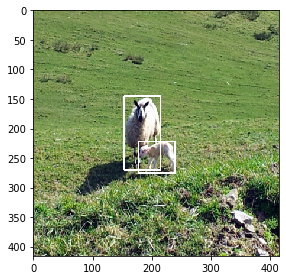

In [98]:
from skimage import io
k=2


boxes=targets[k]['boxes'].numpy()

img=images[k].cpu()
print(img.shape)
mean=torch.tensor([[[0.485, 0.456, 0.406]]]).T
std=torch.tensor([[[0.229, 0.224, 0.225]]]).T
img = (img*std+mean)
img=img*255
img=img.transpose(0,1)
img=img.transpose(1,2)
img=np.array(img.numpy(),dtype=np.uint8)
io.imshow(draw_rect(img,boxes))

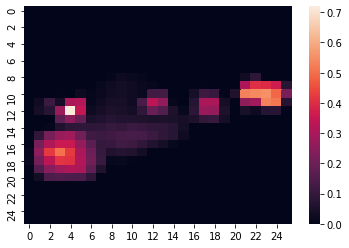

In [106]:
import seaborn as sns
from scipy.special import softmax
scale=1
ar=0

true_iou=no_obj['dd'][k*3+scale].detach().cpu().numpy()[ar]
pred_conf=no_obj['tt'][k*3+scale].detach().cpu().numpy()[ar]

test_pred_conf=softmax(pred_conf)
test_true_iou=softmax(true_iou)
ax = sns.heatmap(true_iou)

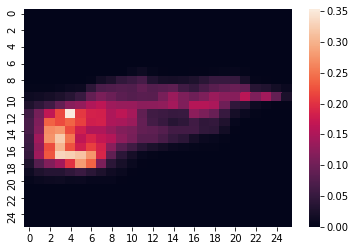

In [107]:
ax=sns.heatmap(pred_conf)

In [85]:
print(true_pred[0,:,4].max(axis=0))

torch.return_types.max(
values=tensor(0.5948, device='cuda:0'),
indices=tensor(1784, device='cuda:0'))


In [63]:
from custom_loss import SinkhornDistance
sinkhorn = SinkhornDistance(eps=0.1, max_iter=100,reduction='sum')
no_obj_conf_loss=0
for i in range(len(no_obj['tt'])):
    dist, P, C = sinkhorn(5*no_obj['dd'][i], 5*no_obj['tt'][i])
    no_obj_conf_loss+=dist
print(dist)

tensor(14.6358, device='cuda:0', grad_fn=<SumBackward0>)


In [4]:
# dist=10
# eps=[]
# mul=[]
# for j in range(1,100):
#     sinkhorn = SinkhornDistance(eps=0.01*j, max_iter=100,reduction='sum')
#     for i in range(1,100):
#         dist, P, C =sinkhorn(torch.tensor(500*0.01*j*true_iou).cuda(),torch.tensor(500*0.01*j*true_iou).cuda())
#         print(dist)

# sns.heatmap(C.cpu().numpy())
# print(dist)
# sns.scatterplot(mul,eps)

In [ ]:
t_mul=np.array(mul)**(1.01)


In [ ]:
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import pandas as pd
import time
import sys
import timeit
from dataset import *
import torchvision.ops.boxes as nms_box
import helper as helper
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
import json

net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph.cuda()
cx_cy=net.cx_cy.cuda()
stride=net.stride.cuda()

start_time = time.time()
'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pth/pretrained32_precomp_obj_soft.pth'
    weights = torch.load(PATH)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if torch.cuda.device_count() > 1:
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
    else:
        model=net

    model.to(device)
    
    
    model.load_state_dict(weights)
    model.eval()
except FileNotFoundError: 
    net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    model=net
    if torch.cuda.device_count() > 3:
      print("Using ", torch.cuda.device_count(), "GPUs!")
      model = nn.DataParallel(net)

    model.to(device)
    model.eval()




print('testing with '+ PATH +'\n')
transformed_dataset=Coco(partition='val',coco_version='2014',subset=0.1,
                                           transform=transforms.Compose([
                                            ResizeToTensor(inp_dim)
                                           ]))



dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=2

dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True,collate_fn=helper.my_collate, num_workers=4)

true_pos=0
false_pos=0
counter=0
iou_threshold=0.5
confidence=0.01
recall_counter=0
max_detections=None
prg_counter=0
annotations=[]
for images,targets,img_meta in dataloader:
#     print(images)
    inp=images.cuda()
    raw_pred = model(inp, torch.cuda.is_available())
    targets,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)

    raw_pred=raw_pred.to(device='cuda')
    true_pred=util.transform(raw_pred.clone(),pw_ph,cx_cy,stride)

    sorted_pred=torch.sort(true_pred[:,:,4],descending=True)
    pred_mask=sorted_pred[0]>confidence
    indices=[(sorted_pred[1][e,:][pred_mask[e,:]]) for e in range(pred_mask.shape[0])]
    pred_final=[true_pred[i,indices[i],:] for i in range(len(indices))]

    pred_final_coord=[util.get_abs_coord(pred_final[i].unsqueeze(-2)) for i in range(len(pred_final))]

    indices=[nms_box.nms(pred_final_coord[i][0],pred_final[i][:,4],iou_threshold) for i in range(len(pred_final))]

    pred_final=[pred_final[i][indices[i],:] for i in range(len(pred_final))]


    abs_pred_final=[helper.convert2_abs_xywh(pred_final[i],img_meta[i]['img_size'],inp_dim) for i in range(len(pred_final))]
    
    annotations=[*annotations,*helper.transform_to_COCO(img_meta,abs_pred_final)]
    sys.stdout.write('\rPgr:'+str(prg_counter/dataset_len*100*batch_size)+'%')
    prg_counter=prg_counter+1
    
    

print("--- %s seconds ---" % (time.time() - start_time))
with open('data.json', 'w') as f:
    json.dump(annotations, f)
# Read txt files containing bounding boxes (ground truth and detections)


In [ ]:
import json

with open('data.json', 'w') as f:
    json.dump(annotations, f)



In [ ]:
annotations[0]

In [ ]:
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import pandas as pd
import time
import sys
import timeit
from dataset import *
import torchvision.ops.boxes as nms_box
import helper as helper
import test as tester
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
import json

net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph.cuda()
cx_cy=net.cx_cy.cuda()
stride=net.stride.cuda()

start_time = time.time()
'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pth/yolo201sds7/yolo2017_best.pth'
    weights = torch.load(PATH)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if torch.cuda.device_count() > 2:
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
    else:
        model=net

    model.to(device)
    
    
    model.load_state_dict(weights)
    model.eval()
except FileNotFoundError: 
    net.load_weights("../yolov3.weights")
    print('orginal weights loaded')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    

    
net.train()

subset=0.0006
coco_version='2014'
confidence=0.1
iou_threshold=0.5


max_detections=100
transformed_dataset=Coco(partition='val',coco_version=coco_version,subset=subset,
                                           transform=transforms.Compose([
                                            ResizeToTensor(inp_dim)
                                           ]))



dataset_len=(len(transformed_dataset))
# print(dataset_len)
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=8

dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=False,collate_fn=helper.my_collate, num_workers=4)


for images,targets,img_name in dataloader:
    inp=images.cuda()
    raw_pred = net(inp, torch.cuda.is_available())
    targets,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)

    raw_pred=raw_pred.to(device='cuda')
    true_pred=util.transform(raw_pred.clone(),pw_ph,cx_cy,stride)
    sorted_pred=torch.sort(true_pred[:,:,4]*(true_pred[:,:,5:].max(axis=2)[0]),descending=True)
    pred_mask=sorted_pred[0]>confidence
    indices=[(sorted_pred[1][e,:][pred_mask[e,:]]) for e in range(pred_mask.shape[0])]
    pred_final=[true_pred[i,indices[i],:] for i in range(len(indices))]
    pred_final_coord=[util.get_abs_coord(pred_final[i].unsqueeze(-2)) for i in range(len(pred_final))]
    
    indices=[nms_box.nms(pred_final_coord[i][0],pred_final[i][:,4],iou_threshold) for i in range(len(pred_final))]

    pred_final=[pred_final[i][indices[i],:] for i in range(len(pred_final))]
    
    abs_pred_final=[helper.convert2_abs_xywh(pred_final[i],img_name[i]['img_size'],inp_dim) for i in range(len(pred_final))]
    
    break
    
#     pred_final[:,0:4]=pred_final[:,0:4]/inp_dim
    helper.write_pred(img_name,pred_final,inp_dim,max_detections,coco_version)



a=tester.evaluate(net, 'cpu',coco_version='2014',confidence=0.1,iou_threshold=0.5,subset=0.0003)

# a=tester.get_map(model, confidence=0.1,iou_threshold=0.5,coco_version='2014',subset=0.0003)


# print(a)
# subset=0.0003

In [ ]:
a=tester.evaluate(net, 'cpu',coco_version='2014',confidence=0.01,iou_threshold=0.5,subset=0.1)

In [ ]:
print(targets.shape)
targets_list=[targets[:13,:],targets[13:,:]]
abs_targets=[helper.convert2_abs_xywh(targets_list[i],img_name[i]['img_size'],1) for i in range(len(targets_list))]
print(abs_targets)

<h1>More efficient Yolo</h1>

In [1]:
from dataset import *
import timeit 
import cv2
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import time
from darknet import *
import util as util
import torch.optim as optim
import test as tester
import sys
import timeit
import torch.autograd
import helper as helper
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import yolo_function as yolo_function


hyperparameters={'lr': 0.0001, 
                 'epochs': 90,
                 'resume_from':0,
                 'coco_version': '2017', #can be either '2014' or '2017'
                 'batch_size': 8,
                 'weight_decay': 0.0005,
                 'momentum': 0.9, 
                 'optimizer': 'sgd', 
                 'alpha': 0.5, 
                 'gamma': 0, 
                 'lcoord': 5,
                 'lno_obj': 0.5,
                 'iou_type': (0, 0, 0),
                 'iou_ignore_thresh': 0.5, 
                 'tfidf': False, 
                 'idf_weights': True, 
                 'tfidf_col_names': ['img_freq', 'none', 'none', 'none', 'no_softmax'],
                 'wasserstein':False,
                 'inf_confidence':0.01,
                 'inf_iou_threshold':0.5,
                 'augment': 0, 
                 'workers': 4,
                 'pretrained':False,
                 'path': 'test_iou', 
                 'reduction': 'sum'}

mode={'bayes_opt':False,
      'debugging':False,
      'show_output':True,
      'multi_gpu':False,
      'show_temp_summary':True,
      'save_summary': False
     }

print(hyperparameters)
if isinstance(hyperparameters['idf_weights'],pd.DataFrame)==False:
    if (hyperparameters['idf_weights']==True):
        hyperparameters['idf_weights']=pd.read_csv('../idf.csv')
    else:
        hyperparameters['idf_weights']=False
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using: ',device)

net = Darknet("../cfg/yolov3.cfg")
coco_version=hyperparameters['coco_version']
inp_dim=net.inp_dim

'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pth/'+hyperparameters['path']+'/'
    checkpoint = torch.load(PATH+hyperparameters['path']+'.tar')
                    # Assuming that we https://pytorch.org/docs/stable/data.html#torch.utils.data.Datasetare on a CUDA machine, this should print a CUDA device:
    net.to(device)

    if (torch.cuda.device_count() > 1)&(mode['multi_gpu']==True):
        model = nn.DataParallel(net)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
    else:
        model=net
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)

    if hyperparameters['optimizer']=='sgd':
        optimizer = optim.SGD(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'], momentum=hyperparameters['momentum'])
    elif hyperparameters['optimizer']=='adam':
        optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    hyperparameters['resume_from']=checkpoint['epoch']

except FileNotFoundError:
    if (hyperparameters['pretrained']==True):
        print("WARNING FILE NOT FOUND INSTEAD USING OFFICIAL PRETRAINED")
        net.load_weights("../yolov3.weights")

        net.to(device)
        if (torch.cuda.device_count() > 1)&(mode['multi_gpu']==True):
            model = nn.DataParallel(net)
            model.to(device)
        else:
            model=net

        if hyperparameters['optimizer']=='sgd':
            optimizer = optim.SGD(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'], momentum=hyperparameters['momentum'])
        elif hyperparameters['optimizer']=='adam':
            optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])
        hyperparameters['resume_from']=0
    else:
        try:
            PATH = '../pth/'+hyperparameters['path']+'/'
            os.mkdir(PATH)
        except FileExistsError:
            pass
#                     print('path already exist')

        if (torch.cuda.device_count() > 1)&(mode['multi_gpu']==True):
            model = nn.DataParallel(net)
            model.to(device)
        else:
            model=net
            model.to(device)

        if hyperparameters['optimizer']=='sgd':
            optimizer = optim.SGD(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'], momentum=hyperparameters['momentum'])
        elif hyperparameters['optimizer']=='adam':
            optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])
        hyperparameters['resume_from']=0
    
    
if(mode['show_temp_summary']==True):
    writer = SummaryWriter('../results/test_vis/')



if hyperparameters['augment']>0:
    train_dataset=Coco(partition='train',coco_version=coco_version,subset=0.0005,transform=transforms.Compose([Augment(hyperparameters['augment']),ResizeToTensor(inp_dim)]))
else:
    train_dataset=Coco(partition='train',coco_version=coco_version,subset=0.0005,transform=transforms.Compose([ResizeToTensor(inp_dim)]))
    
dataset_len=(len(train_dataset))
print('the length of the dataset is: ',dataset_len)
batch_size=hyperparameters['batch_size']
mAP_best=0

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=5)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True,collate_fn=helper.collate_fn, num_workers=hyperparameters['workers'])


for i in range(hyperparameters['epochs']):
    outcome=yolo_function.train_one_epoch(model,optimizer,train_dataloader,hyperparameters,mode)
#     mAP=test.evaluate(model, device,coco_version,confidence=hyperparameters['inf_confidence'],iou_threshold=hyperparameters['inf_iou_threshold'])
    scheduler.step(outcome['avg_loss'])
    if(mode['save_summary']==True):
        writer = SummaryWriter('../results/'+hyperparameters['path'])
        writer.add_scalar('Loss/train', outcome['avg_loss'], hyperparameters['resume_from'])
        writer.add_scalar('AIoU/train', outcome['avg_iou'], hyperparameters['resume_from'])
        writer.add_scalar('PConf/train', outcome['avg_conf'], hyperparameters['resume_from'])
        writer.add_scalar('NConf/train', outcome['avg_no_conf'], hyperparameters['resume_from'])
        writer.add_scalar('PClass/train', outcome['avg_pos'], hyperparameters['resume_from'])
        writer.add_scalar('NClass/train', outcome['avg_neg'], hyperparameters['resume_from'])
        
        writer.add_scalar('mAP/valid', mAP, hyperparameters['resume_from'])

#     torch.save({
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'avg_loss': outcome['avg_loss'],
#             'avg_iou': outcome['avg_iou'],
#             'avg_pos': outcome['avg_pos'],
#             'avg_neg':outcome['avg_neg'],
#             'avg_conf': outcome['avg_conf'],
#             'avg_no_conf': outcome['avg_no_conf'],
#             'epoch':hyperparameters['resume_from']+1,
#             'mAP': mAP
#             }, PATH+hyperparameters['path']+'.tar')

        
#     if mAP>mAP_best:
#         torch.save(checkpoint, PATH+hyperparameters['path']+'_best.tar')
#         mAP_best=mAP
        
    

{'lr': 0.0001, 'epochs': 90, 'resume_from': 0, 'coco_version': '2017', 'batch_size': 8, 'weight_decay': 0.0005, 'momentum': 0.9, 'optimizer': 'sgd', 'alpha': 0.5, 'gamma': 0, 'lcoord': 5, 'lno_obj': 0.5, 'iou_type': (0, 0, 0), 'iou_ignore_thresh': 0.5, 'tfidf': False, 'idf_weights': True, 'tfidf_col_names': ['img_freq', 'none', 'none', 'none', 'no_softmax'], 'wasserstein': False, 'inf_confidence': 0.01, 'inf_iou_threshold': 0.5, 'augment': 0, 'workers': 4, 'pretrained': False, 'path': 'test_iou', 'reduction': 'sum'}
Using:  cuda:0
the length of the dataset is:  58
Pgr:110.34482758620689% L:18.30083465576172 IoU:0.5205330848693848 pob:0.004596896003931761 nob:0.0022372857201844454 PCls:0.014163756743073463 ncls:0.01247893925756216649

KeyboardInterrupt: 

In [2]:
print(checkpoint['epoch'])

1


In [ ]:
torch.save({
'model_state_dict': model.state_dict(),
'optimizer_state_dict': optimizer.state_dict(),
'avg_loss': 0,
'avg_iou': 0,
'avg_pos': 0,
'avg_neg':0,
'avg_conf': 0,
'avg_no_conf': 0,
'epoch':hyperparameters['resume_from']
}, PATH+hyperparameters['path']+'.tar')

In [ ]:
hyperparameters['idf_weights']=True

In [ ]:
from dataset import *
import timeit 
import cv2
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import time
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import sys
import timeit
import torch.autograd
import helper as helper
import pandas as pd
from torch import autograd
import test as tester
import yolo_function



net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph.to(device='cuda')
cx_cy=net.cx_cy.to(device='cuda')
stride=net.stride.to(device='cuda')
print('YOLO version2')

hyperparameters={'lr': 0.00001, 
                 'epochs': 90,
                 'resume_from':15,
                 'coco_version': '2017', #can be either '2014' or '2017'
                 'batch_size': 8,
                 'weight_decay': 0.0005,
                 'momentum': 0.9, 
                 'optimizer': 'sgd', 
                 'alpha': 0.5, 
                 'gamma': 0, 
                 'lcoord': 1,
                 'lno_obj': 0.5,
                 'iou_type': (1, 0, 0),
                 'iou_ignore_thresh': 0.5, 
                 'tfidf': False, 
                 'idf_weights': True, 
                 'tfidf_col_names': ['img_freq', 'none', 'none', 'none', 'no_softmax'],
                 'inf_confidence':0.01,
                 'inf_iou_threshold':0.5,
                 'augment': 0, 
                 'workers': 0, 
                 'path': 'yolo2017', 
                 'reduction': 'sum'}


bayes_opt=True
mode={'bayes_opt':bayes_opt,
      'debugging':False,
      'show_output':True,
      'multi_gpu':False,
      'show_temp_summary':False,
      'save_summary': bayes_opt==False
     }

print(hyperparameters)
coco_version=hyperparameters['coco_version']
if (hyperparameters['idf_weights']==True):
    hyperparameters['idf_weights']=pd.read_csv('../idf.csv')
else:
    hyperparameters['idf_weights']=False
        
'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pth/'+hyperparameters['path']+'/'
    weights = torch.load(PATH+hyperparameters['path']+'_best.pth')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we https://pytorch.org/docs/stable/data.html#torch.utils.data.Datasetare on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if (torch.cuda.device_count() > 2):
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
        model.load_state_dict(weights)
    else:
        model=net
        model.to(device)
        model.load_state_dict(weights)
        
except FileNotFoundError:
    try:
        os.mkdir(PATH)
    except FileExistsError:
        print('path already exist')
    net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    if (torch.cuda.device_count() > 2):
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
    else:
        model=net
        
if hyperparameters['augment']>0:
    transformed_dataset=Coco(partition='train',coco_version=coco_version,subset=0.001,transform=transforms.Compose([Augment(hyperparameters['augment']),ResizeToTensor(inp_dim)]))
else:
    transformed_dataset=Coco(partition='train',coco_version=coco_version,subset=0.001,transform=ResizeToTensor(inp_dim))
    


dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=hyperparameters['batch_size']
dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True,collate_fn=helper.collate_fn, num_workers=hyperparameters['workers'])


if hyperparameters['optimizer']=='sgd':
    optimizer = optim.SGD(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'], momentum=hyperparameters['momentum'])
elif hyperparameters['otimizer']=='adam':
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])

    
outcome=yolo_function.train_one_epoch(model,optimizer,dataloader,hyperparameters,mode)
tester.evaluate(model, device,coco_version,confidence=0.01,iou_threshold=0.5,subset=0.01)



    

In [ ]:
print(optimizer)